In [1]:
using Plots, AnalogDataAssimilation, DifferentialEquations, Random, LinearAlgebra

# TEST ON LORENZ-96

We also test the analog data assimilation procedure on the 40-dimensional Lorenz-96 dynamical model. As in the previous experiment, we generate state and observation data as well as simulated trajectories of the Lorenz-96 model in order to emulate the dynamical model. Here, we compare two analog data assimilation strategies: the global and local analog forecasting, respectively defined in finding similar situations on the whole 40 variables or on 5 variables recursively.

In [2]:
rng = MersenneTwister(123)
F = 8
J = 40 :: Int64
parameters = [F, J]
dt_integration = 0.05 # integration time
dt_states = 1 # number of integration times between consecutive states (for xt and catalog)
dt_obs = 4 # number of integration times between consecutive observations (for yo)
var_obs = randperm(rng, J)[1:20] # indices of the observed variables
nb_loop_train = 20 # size of the catalog
nb_loop_test = 5 # size of the true state and noisy observations
sigma2_catalog = 0.   # variance of the model error to generate the catalog   
sigma2_obs = 2. # variance of the observation error to generate observations

ssm = StateSpaceModel( lorenz96, 
                       dt_integration, dt_states, dt_obs, 
                       parameters, var_obs,
                       nb_loop_train, nb_loop_test,
                       sigma2_catalog, sigma2_obs )

StateSpaceModel(AnalogDataAssimilation.lorenz96, 0.05, 1, 4, [8.0, 40.0], [8, 29, 21, 3, 22, 20, 38, 19, 24, 9, 14, 33, 26, 31, 40, 25, 30, 13, 17, 1], 20, 5, 0.0, 2.0)

Go to time = 2 to be in the attractor space

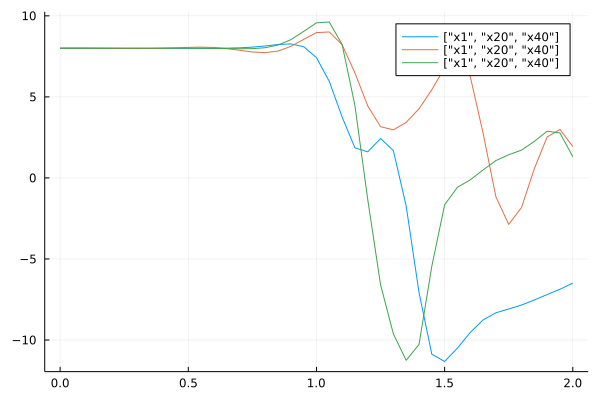

In [6]:
u0 = F .* ones(Float64, J)
u0[J÷2] = u0[J÷2] + 0.01

tspan = (0.0,2.0)
p = [F, J]
prob  = ODEProblem(lorenz96, u0, tspan, p)
sol = solve(prob, saveat= dt_integration)
x1  = getindex.(sol.u, 1)
x20 = getindex.(sol.u, 20)
x40 = getindex.(sol.u, 40)
u0 = last(sol.u);
plot(sol.t, [x1 x20 x40], labels=["x1", "x20", "x40"])

Run the data generation

In [7]:
xt, yo, catalog = generate_data(ssm, u0);

### PLOT STATE, OBSERVATIONS AND CATALOG

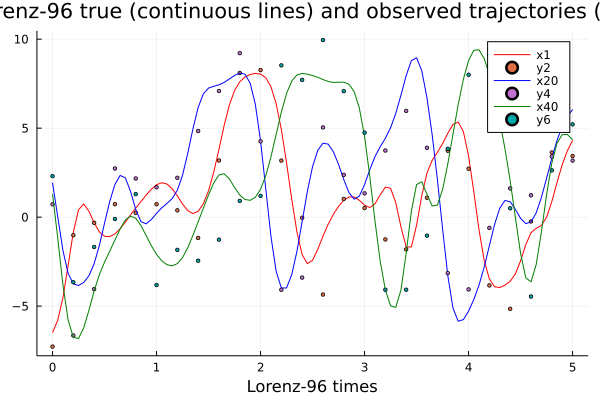

In [8]:
plot(xt.t,  xt[1], line=(:solid,:red), label="x1")
scatter!(yo.t, yo[1], markersize=2)
plot!(xt.t, xt[20], line=(:solid,:blue), label="x20")
scatter!(yo.t, yo[20], markersize=2)
plot!(xt.t, xt[40], line=(:solid,:green), label="x40")
scatter!(yo.t, yo[40], markersize=2)
xlabel!("Lorenz-96 times")
title!("Lorenz-96 true (continuous lines) and observed trajectories (dots)")

### MODEL DATA ASSIMILATION (with the global analogs)

In [10]:
DA = DataAssimilation( ssm, xt )
@time x̂_classical_global  = forecast(DA, yo, AnEnKS(500));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  6.415053 seconds (13.22 M allocations: 1.626 GiB, 9.82% gc time, 86.13% compilation time)


In [11]:
RMSE(xt, x̂_classical_global)

0.5069927925009423

In [12]:
local_analog_matrix =  BitArray{2}(diagm( -2  => trues(xt.nv-2),
             -1  => trues(xt.nv-1),
              0  => trues(xt.nv),
              1  => trues(xt.nv-1),
              2  => trues(xt.nv-2),             
             J-2 => trues(xt.nv-(J-2)),
             J-1 => trues(xt.nv-(J-1)))
    + transpose(diagm( J-2 => trues(xt.nv-(J-2)),
             J-1 => trues(xt.nv-(J-1))))
    );

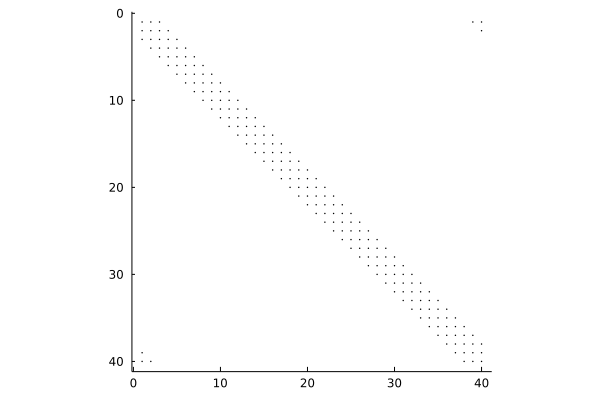

In [16]:
spy(local_analog_matrix)

To define the local or global analog forecasting, we generate different matrices that will be use as the "AF.neighborhood" argument. For each variable of the system, we use 0 or 1 to indicate the absence or presence of other variables in the analog forecasting procedure. For instance, in the local analog matrix defined above, to predict the variable $x_2$ at time t+dt, we will use the local variables $x_1$, $x_2$, $x_3$, $x_4$ and $x_{40}$ at time t.

### ANALOG DATA ASSIMILATION (with the global analogs)

In [17]:
regression = :local_linear
sampling = :gaussian
f  = AnalogForecasting( 100, xt, catalog, regression=regression, sampling=sampling)
DA_global = DataAssimilation( f, xt, ssm.sigma2_obs )
@time x̂_analog_global  = forecast(DA_global, yo, AnEnKS(500))
println(RMSE(xt, x̂_analog_global))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 68.436948 seconds (34.72 M allocations: 21.526 GiB, 6.04% gc time, 0.92% compilation time)
2.5501078218123157


Use classic method for analog forecasting

In [19]:
DA = DataAssimilation( f, xt, ssm.sigma2_obs )
@time x̂_analog_global  = forecast(DA, yo, AnEnKS(500))
RMSE(xt, x̂_analog_global)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 67.065404 seconds (33.46 M allocations: 21.455 GiB, 6.02% gc time)


2.5736373929251934

### ANALOG DATA ASSIMILATION (with the local analogs)

In [21]:
neighborhood = local_analog_matrix
regression = :local_linear
sampling   = :gaussian
f  = AnalogForecasting( 100, xt, catalog, neighborhood, regression, sampling)
DA = DataAssimilation( f, xt, ssm.sigma2_obs )
@time x̂_analog_local  = forecast(DA, yo, AnEnKS(500))
RMSE(xt, x̂_analog_local)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


109.152504 seconds (1.32 G allocations: 73.393 GiB, 10.45% gc time)


1.9189439893961326

### COMPARISON BETWEEN GLOBAL AND LOCAL ANALOG DATA ASSIMILATION

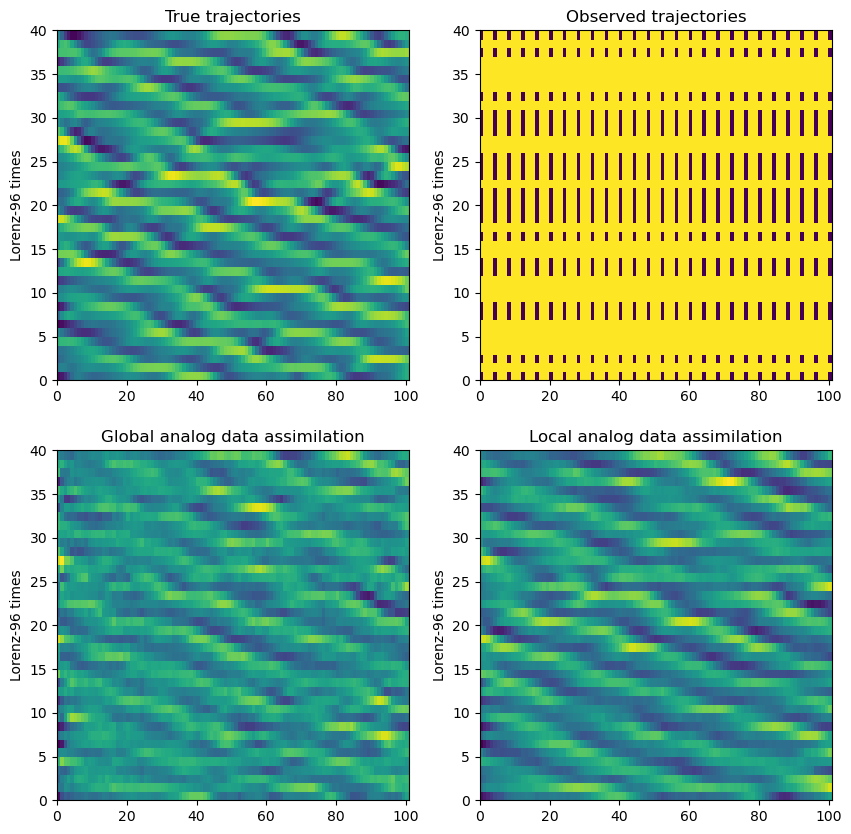

PyObject Text(0.5, 1.0, 'Local analog data assimilation')

In [25]:
import PyPlot
fig = PyPlot.figure(figsize=(10,10))
PyPlot.subplot(221)
PyPlot.pcolormesh(hcat(xt.u...))
PyPlot.ylabel("Lorenz-96 times")
PyPlot.title("True trajectories")
PyPlot.subplot(222)
PyPlot.pcolormesh(isnan.(hcat(yo.u...)))
PyPlot.ylabel("Lorenz-96 times")
PyPlot.title("Observed trajectories")
PyPlot.subplot(223)
PyPlot.pcolormesh(hcat(x̂_analog_global.u...))
PyPlot.ylabel("Lorenz-96 times")
PyPlot.title("Global analog data assimilation")
PyPlot.subplot(224)
PyPlot.pcolormesh(hcat(x̂_analog_local.u...))
PyPlot.ylabel("Lorenz-96 times")
PyPlot.title("Local analog data assimilation")

# error

In [26]:
println("RMSE(global analog DA) = $(RMSE(xt,x̂_analog_global))")
println("RMSE(local analog DA)  = $(RMSE(xt,x̂_analog_local))")

RMSE(global analog DA) = 2.5736373929251934
RMSE(local analog DA)  = 1.9189439893961326


The results show that the global analog strategy do not reach satisfying results. Indeed, it is difficult to find relevant nearest neighboors on 40-dimensional vectors. The only way to improve the results in such a global strategy is to deeply increase the size of the catalog. At the contrary, in the local analog data assimilation, we are able to track correctly the true trajectories, even with a short catalog.

# Remark

Note that for all the previous experiments, we use the robust Ensemble Kalman Smoother (EnKS) with the increment or local linear regressions and the Gaussian sampling. If you want to have realistic state estimations, we preconize the use of the Particle Filter (DA.method = 'PF') with the locally constant regression (AF.regression = 'locally_constant') and the multinomial sampler (AF.sampling = 'multinomial') with a large number of particles (DA.N). For more details about the different options, see the attached publication: Lguensat, R., Tandeo, P., Ailliot, P., Pulido, M., & Fablet, R. (2017). The Analog Data Assimilation. *Monthly Weather Review*, 145(10), 4093-4107.